In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
#from xgboost import xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.metrics import fbeta_score, make_scorer

mae = make_scorer(new_mae,greater_is_better=False)

**Outline**
- importing data
- check the data type for all columns and transform them if necessary
- Create new features
- removing outliers
- imputing missing values
- checking distributions, correlation plot and scatter plots
- Modeling: RandomForest regression, Linear Regression, XGboost regression
- Preprocessing and prediction on predict_data




In [2]:
#### importing the historical data and data to be used for predicting

hist_data = pd.read_csv('historical_data.csv')
predict_data = pd.read_csv('predict_data.csv')
hist_data.head()


,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.0,0.0,0.0,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900,1.0,1.0,2.0,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900,6.0,6.0,9.0,650.0


In [3]:
hist_data.dtypes

market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
subtotal                                          int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_store_to_consumer_driving_duration    float64
dtype: object

In [5]:
### changing the data type of the created_at and actual_delivery_time for both historical data and predict data so calculations can be done on them

## historical data
hist_data['created_at']= pd.to_datetime(hist_data['created_at'])
hist_data['actual_delivery_time']= pd.to_datetime(hist_data['actual_delivery_time'])

## predict data
predict_data['created_at']= pd.to_datetime(predict_data['created_at'])



## Some new features to be created
- total_delivery_duration: This is the variable to be predicted which is the (actual_delivery_time-created_at)
- hour_of_day: Time of the day can be a good predicted in estimating the delivery time. Early morning and evenings(rush hour during week days), I would expect this to play a role in the traffic situation on the road which affects delivery time
- Day_of_week: The day of the week can also help greatly in determining the delivery time too  in that traffic patterns during weekends and weekdays can hahve a pattern.


#### Creating these new features for the historical data

In [6]:
## creating total_delivery_duration  feature
hist_data['total_delivery_duration']= (hist_data['actual_delivery_time']-hist_data['created_at']).astype("timedelta64[s]")

## creating the hour_of_day variable
# The idea is to bin the hour of day into four categories(time_of_day) which I think define users eating behavior.
# breakfast=(6 a.m. - 11 a.m.), lunch = (12 p.m. -3p.m.), dinner =(4 p.m. - 10 p.m.), late-night meals= (11 p.m. - 4a.m.).

hist_data['time_of_day']=pd.cut(hist_data['created_at'].dt.hour, bins=[0,4,11,15,22], labels=['late_night','morning','lunch','dinner'])

# since the late night category runs from after 10pm, fill in the missing values with late night since this range isnt included in the binning.

hist_data['time_of_day']=hist_data['time_of_day'].fillna(value='late_night')

## creating a day_of_week variable. It starts from Monday(0), Tuesday(1), Wednesday(2).... Sunday(6)
hist_data['day_of_week']= hist_data['created_at'].dt.weekday

#### creating new features for the predict data

In [7]:
## creating the hour_of_day variable
# The idea is to bin the hour of day into four categories(time_of_day) which I think define users eating behavior.
# breakfast=(6 a.m. - 11 a.m.), lunch = (12 p.m. -3p.m.), dinner =(4 p.m. - 10 p.m.), late-night meals= (11 p.m. - 4a.m.).

predict_data['time_of_day']=pd.cut(predict_data['created_at'].dt.hour, bins=[0,4,11,15,22], labels=['late_night','morning','lunch','dinner'])

# since the late night category runs from after 10pm, fill in the missing values with late night since this range isnt included in the binning.

predict_data['time_of_day']=predict_data['time_of_day'].fillna(value='late_night')

## creating a day_of_week variable. It starts from Monday(0), Tuesday(1), Wednesday(2).... Sunday(6)
predict_data['day_of_week']= predict_data['created_at'].dt.weekday

In [8]:
hist_data.describe()

,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,total_delivery_duration,day_of_week
count,196441.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,196902.000000,1.974210e+05,197428.000000
mean,2.978706,3530.510272,2682.331402,44.808093,41.739747,58.050065,545.358935,2.908257e+03,3.218966
std,1.524867,2053.496711,1823.093688,34.526783,32.145733,52.661830,219.352902,1.922961e+04,2.045789
min,1.000000,1.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,1.010000e+02,0.000000
25%,2.000000,1686.000000,1400.000000,17.000000,15.000000,17.000000,382.000000,2.104000e+03,1.000000
50%,3.000000,3592.000000,2200.000000,37.000000,34.000000,41.000000,544.000000,2.660000e+03,3.000000
75%,4.000000,5299.000000,3395.000000,65.000000,62.000000,85.000000,702.000000,3.381000e+03,5.000000
max,6.000000,6987.000000,27100.000000,171.000000,154.000000,285.000000,2088.000000,8.516859e+06,6.000000


In [9]:
##splitting the historical data into train and test before preprocessing so information like mean etc which is used in computing missing values etc arent seen by the test data for model selection

train_data, valid_data= train_test_split(hist_data, test_size=0.3, random_state=42)


## Observations 

- from the description 'total_onshift_dashers', 'total_busy_dashers','total_outstanding_orders' have minimum values to be negative which doesnt make sense.
- Also from the data description, total_busy_dashers should alweays be less than total_onshift_dashers

## Question
- What resulted in these negatives values?
- How to deal with values, drop them or absolute them??
- why are values in the total_busy_dasher in greater total_onsight_dashers?? wrong data input??

## To Do's 
- Two options here, get the absolute of those valuess or drop the rows containing those
- And also for rows where total_busy_dashers is great than total_onshift_dashers, the ototal_onshift_dashers value will be replaced with total_busy_dashers

In [10]:

## function used to make total_onshift_dashers equal to total_busy_dashers if 
def uplevel_onshift_dashers(x):
    if x[0] >=x[1]:
        return x[0]
    else:
        return x[1]
    
## dealing with bad data function, absolutes negative values and apply the uplevel_onshift_dashers above.
def dealing_bad_data(data):
    columns = ['total_onshift_dashers','total_busy_dashers','total_outstanding_orders']
    for column in columns:
        ### absolute negative values
        data[column] = abs(data[column])
        
        
    data['total_onshift_dashers'] = data[['total_onshift_dashers','total_busy_dashers']].apply(uplevel_onshift_dashers, axis=1)
        
    return data


In [11]:
##### dealing with bad data in training data
train_data  = dealing_bad_data(train_data)

C:\Users\tetteh\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\tetteh\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [12]:
##### dealing with bad data in validation data
valid_data  = dealing_bad_data(valid_data)

C:\Users\tetteh\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\tetteh\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [13]:
train_data.shape

(138199, 12)

In [14]:
valid_data.shape

(59229, 12)

### visualizing with boxplot to check for outliers
- And from the visualizations below, all these features has outliers. Hence I will be using the remove_outliers function to remove all row corresponding to the outliers of these columns

In [15]:
def remove_outliers(data,column):
    
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3-Q1
    upper = (Q3+1.5*IQR)
    lower = (Q3-1.5*IQR)
    data = data[~(data[column]>upper)] ### only using upper because from the boxplots, all the outliers are upper
    data = data[~(data[column]<lower)]
    
    return data


In [16]:
#plt.boxplot(train_data[['total_onshift_dashers','total_busy_dashers']])

# ax = train_data[['total_onshift_dashers','total_busy_dashers','total_outstanding_orders']].plot(kind='box', title='boxplot', showmeans=True)

# plt.show()

C:\Users\tetteh\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


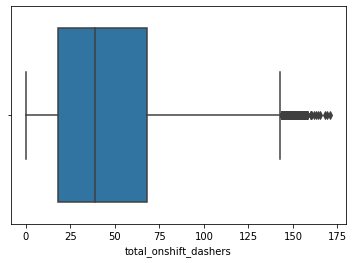

In [17]:
sns.boxplot(train_data['total_onshift_dashers'])

C:\Users\tetteh\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


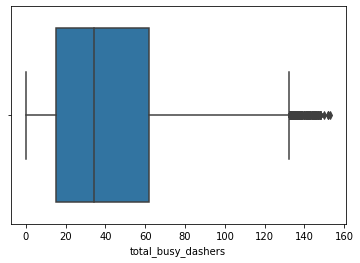

In [18]:
sns.boxplot(train_data['total_busy_dashers'])

C:\Users\tetteh\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


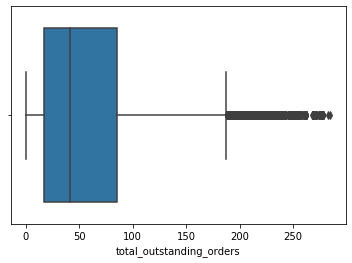

In [19]:
sns.boxplot(train_data['total_outstanding_orders'])

C:\Users\tetteh\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


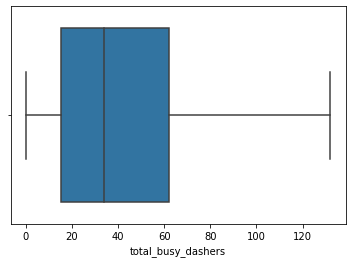

In [20]:
train_data=remove_outliers(train_data, 'total_busy_dashers')
sns.boxplot(train_data['total_busy_dashers'])

C:\Users\tetteh\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


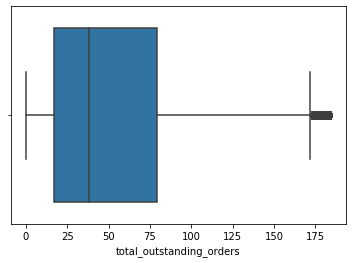

In [21]:
train_data=remove_outliers(train_data, 'total_outstanding_orders')
sns.boxplot(train_data['total_outstanding_orders'])

C:\Users\tetteh\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


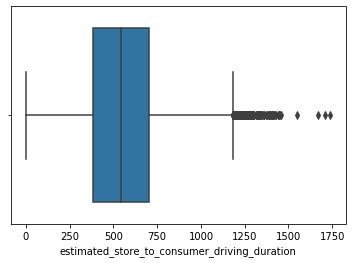

In [22]:
##plotting these two separately to make visualization nice since they have far larger range of values

sns.boxplot(train_data['estimated_store_to_consumer_driving_duration'])

C:\Users\tetteh\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


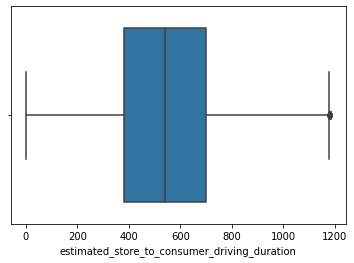

In [23]:
train_data=remove_outliers(train_data, 'estimated_store_to_consumer_driving_duration')
sns.boxplot(train_data['estimated_store_to_consumer_driving_duration'])

C:\Users\tetteh\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


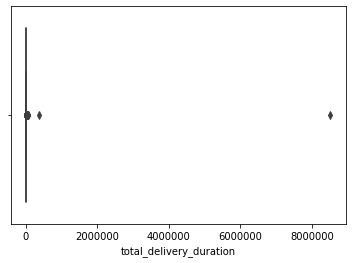

In [24]:
sns.boxplot(train_data['total_delivery_duration'])

C:\Users\tetteh\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


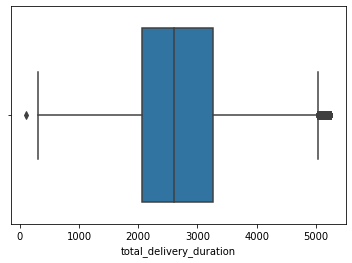

In [25]:
train_data=remove_outliers(train_data, 'total_delivery_duration')
sns.boxplot(train_data['total_delivery_duration'])

## MISSING VALUES

### Approach:
- 1: Missing values are imputed using the average of the column after grouping by market_id and the time_of_day. This replaces missing values based on location and time of the day.
- 2: For rows with missing market_id, it will just be imputed using the time of the day

In [27]:
## missing value imputation for training data
## the missing value is replaced by the average of the column grouped by market_id and time of the day
train_data['total_onshift_dashers'] = train_data['total_onshift_dashers'].fillna(train_data.groupby(by=['market_id','time_of_day'])['total_onshift_dashers'].transform('mean'))

train_data['total_busy_dashers'] = train_data['total_busy_dashers'].fillna(train_data.groupby(by=['market_id','time_of_day'])['total_busy_dashers'].transform('mean'))

train_data['total_outstanding_orders'] = train_data['total_outstanding_orders'].fillna(train_data.groupby(by=['market_id','time_of_day'])['total_outstanding_orders'].transform('mean'))

train_data['estimated_store_to_consumer_driving_duration'] = train_data['estimated_store_to_consumer_driving_duration'].fillna(train_data.groupby(by=['market_id','time_of_day'])['estimated_store_to_consumer_driving_duration'].transform('mean'))




## since the averages computed were grouped by market_id and time of the day, some columns without market_id wouldnt be computed
## Hence for columns without market_id, missing values will be computed using the mean of the column


train_data['total_onshift_dashers'] = train_data['total_onshift_dashers'].fillna(train_data['total_onshift_dashers'].mean())

train_data['total_busy_dashers'] = train_data['total_busy_dashers'].fillna(train_data['total_busy_dashers'].mean())

train_data['total_outstanding_orders'] = train_data['total_outstanding_orders'].fillna(train_data['total_outstanding_orders'].mean())

train_data['estimated_store_to_consumer_driving_duration'] = train_data['estimated_store_to_consumer_driving_duration'].fillna(train_data['estimated_store_to_consumer_driving_duration'].mean())


In [28]:
## imputing for validation data
valid_data['total_onshift_dashers'] = valid_data['total_onshift_dashers'].fillna(valid_data.groupby(by=['time_of_day'])['total_onshift_dashers'].transform('mean'))

valid_data['total_busy_dashers'] = valid_data['total_busy_dashers'].fillna(valid_data.groupby(by=['time_of_day'])['total_busy_dashers'].transform('mean'))

valid_data['total_outstanding_orders'] = valid_data['total_outstanding_orders'].fillna(valid_data.groupby(by=['time_of_day'])['total_outstanding_orders'].transform('mean'))

valid_data['estimated_store_to_consumer_driving_duration'] = valid_data['estimated_store_to_consumer_driving_duration'].fillna(valid_data.groupby(by=['time_of_day'])['estimated_store_to_consumer_driving_duration'].transform('mean'))




## since the averages computed were grouped by market_id and time of the day, some columns without market_id wouldnt be computed
## Hence for columns without market_id, missing values will be computed using just the time of the day

valid_data['total_onshift_dashers'] = valid_data['total_onshift_dashers'].fillna(train_data['total_onshift_dashers'].mean())

valid_data['total_busy_dashers'] = valid_data['total_busy_dashers'].fillna(train_data['total_busy_dashers'].mean())

valid_data['total_outstanding_orders'] = valid_data['total_outstanding_orders'].fillna(train_data['total_outstanding_orders'].mean())

valid_data['estimated_store_to_consumer_driving_duration'] = valid_data['estimated_store_to_consumer_driving_duration'].fillna(train_data['estimated_store_to_consumer_driving_duration'].mean())

C:\Users\tetteh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\tetteh\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\tetteh\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [29]:
valid_data.isnull().sum()

market_id                                       281
created_at                                        0
actual_delivery_time                              2
store_id                                          0
subtotal                                          0
total_onshift_dashers                             0
total_busy_dashers                                0
total_outstanding_orders                          0
estimated_store_to_consumer_driving_duration      0
total_delivery_duration                           2
time_of_day                                       0
day_of_week                                       0
dtype: int64

In [30]:
predict_data.isnull().sum()

market_id                                        250
created_at                                         0
store_id                                           0
subtotal                                           0
total_onshift_dashers                           4633
total_busy_dashers                              4633
total_outstanding_orders                        4633
estimated_store_to_consumer_driving_duration      11
delivery_id                                        0
time_of_day                                        0
day_of_week                                        0
dtype: int64

In [31]:
computed_averages_from_train_data = train_data[['market_id','time_of_day','total_onshift_dashers','total_busy_dashers','total_outstanding_orders','estimated_store_to_consumer_driving_duration']].groupby(by=['market_id','time_of_day'], as_index = False).mean()[['market_id','time_of_day','total_onshift_dashers','total_busy_dashers','total_outstanding_orders','estimated_store_to_consumer_driving_duration']]

predict_data = predict_data.merge(computed_averages_from_train_data, on=['market_id','time_of_day'],how='left')

## missing value imputation for training data
predict_data['total_onshift_dashers_x'] = predict_data['total_onshift_dashers_x'].fillna(predict_data['total_onshift_dashers_y'])
predict_data['total_busy_dashers_x'] = predict_data['total_busy_dashers_x'].fillna(predict_data['total_busy_dashers_y'])
predict_data['total_outstanding_orders_x'] = predict_data['total_outstanding_orders_x'].fillna(predict_data['total_outstanding_orders_y'])
predict_data['estimated_store_to_consumer_driving_duration_x'] = predict_data['estimated_store_to_consumer_driving_duration_x'].fillna(predict_data['estimated_store_to_consumer_driving_duration_y'])



predict_data['total_onshift_dashers_x'] = predict_data['total_onshift_dashers_x'].fillna(train_data['total_onshift_dashers'].mean())
predict_data['total_busy_dashers_x'] = predict_data['total_busy_dashers_x'].fillna(train_data['total_busy_dashers'].mean())
predict_data['total_outstanding_orders_x'] = predict_data['total_outstanding_orders_x'].fillna(train_data['total_outstanding_orders'].mean())
predict_data['estimated_store_to_consumer_driving_duration_x'] = predict_data['estimated_store_to_consumer_driving_duration_x'].fillna(train_data['estimated_store_to_consumer_driving_duration'].mean())



## selecting main columns
predict_data = predict_data[['market_id', 'created_at', 'store_id', 'subtotal',
       'total_onshift_dashers_x', 'total_busy_dashers_x',
       'total_outstanding_orders_x',
       'estimated_store_to_consumer_driving_duration_x', 'delivery_id',
       'time_of_day', 'day_of_week']]



## renaming columns
predict_data.columns = ['market_id', 'created_at', 'store_id', 'subtotal',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', 'delivery_id',
       'time_of_day', 'day_of_week']

In [32]:
predict_data.columns = ['market_id', 'created_at', 'store_id', 'subtotal',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration', 'delivery_id',
       'time_of_day', 'day_of_week']

# Some visualization and transformation

- numerical columns(total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration) that are right skewed are transformed using the square root transform

- This is done since I will be building somelinear models.

##### Training Data

[Text(0.5, 1.0, 'total_onshift_dashers')]

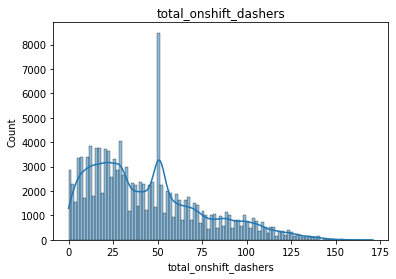

In [33]:
##### 
sns.histplot(data=train_data, x='total_onshift_dashers',kde=True).set(title='total_onshift_dashers')

[Text(0.5, 1.0, 'total_busy_dashers')]

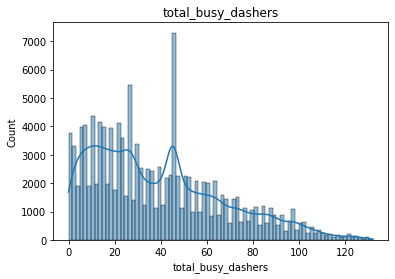

In [34]:
sns.histplot(data=train_data, x='total_busy_dashers',kde=True).set(title='total_busy_dashers')

[Text(0.5, 1.0, 'total_outstanding_orders')]

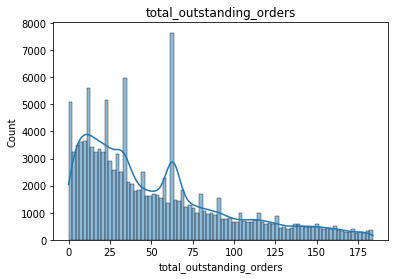

In [35]:
sns.histplot(data=train_data, x='total_outstanding_orders',kde=True).set(title='total_outstanding_orders')

[Text(0.5, 1.0, 'subtotal')]

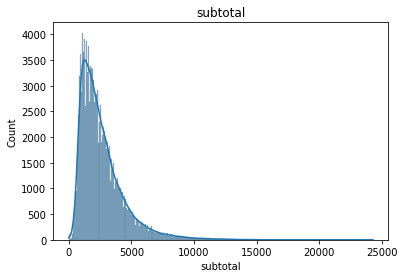

In [36]:
sns.histplot(data=train_data, x='subtotal',kde=True).set(title='subtotal')

In [37]:
train_data.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'subtotal', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders',
       'estimated_store_to_consumer_driving_duration',
       'total_delivery_duration', 'time_of_day', 'day_of_week'],
      dtype='object')

[Text(0.5, 1.0, 'total_delivery_duration')]

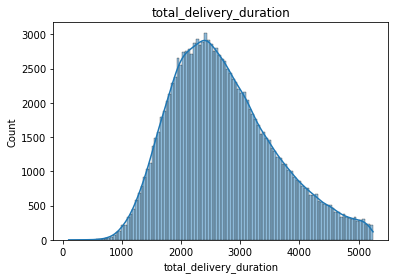

In [38]:
sns.histplot(data=train_data, x='total_delivery_duration',kde=True).set(title='total_delivery_duration')

In [39]:
#### function to square root transform some columns

## Note: I tried different forms of tranformation like the log transform but the sqrt transform works better

def sqrt_transform(data):
    columns = ['total_onshift_dashers','total_busy_dashers','total_outstanding_orders','subtotal']
    for i in columns:
        data[i] = np.sqrt(data[i])   
 
    
    return data


    
        
    

In [40]:
transform_train_data = sqrt_transform(train_data)
train_data = train_data[['market_id','total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'subtotal','estimated_store_to_consumer_driving_duration', 'time_of_day', 'day_of_week',
       'total_delivery_duration']]


In [41]:
train_data.head()

,market_id,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,subtotal,estimated_store_to_consumer_driving_duration,time_of_day,day_of_week,total_delivery_duration
148761,4.0,8.602325,8.602325,5.099020,51.961524,674.0,late_night,5,2773.0
20248,4.0,10.770330,8.944272,12.409674,42.308392,541.0,late_night,6,2922.0
33210,5.0,5.196152,3.741657,3.741657,51.623638,231.0,late_night,0,2537.0
32256,1.0,7.141428,7.000000,7.681146,40.000000,862.0,late_night,4,3058.0
1305,5.0,5.099020,5.099020,6.403124,78.898669,573.0,late_night,5,2563.0



##### visualizing after transformation

- Since I will be bilding some linear models and some of the columns are skewed, transforming them to make them look more normal

[Text(0.5, 1.0, 'total_onshift_dashers')]

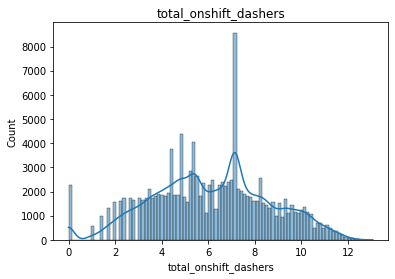

In [42]:
sns.histplot(data=train_data, x='total_onshift_dashers',kde=True).set(title='total_onshift_dashers')

[Text(0.5, 1.0, 'total_busy_dashers')]

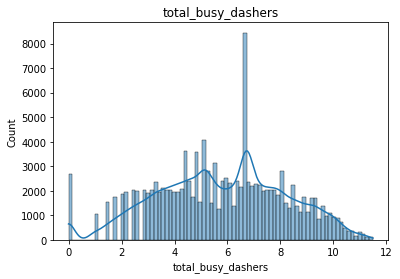

In [43]:
sns.histplot(data=train_data, x='total_busy_dashers',kde=True).set(title='total_busy_dashers')

[Text(0.5, 1.0, 'total_outstanding_orders')]

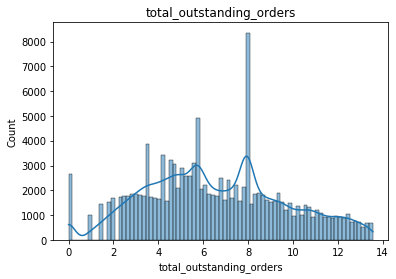

In [44]:
sns.histplot(data=train_data, x='total_outstanding_orders',kde=True).set(title='total_outstanding_orders')

[Text(0.5, 1.0, 'subtotal')]

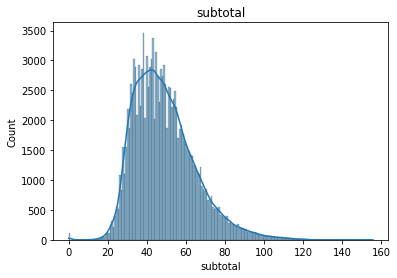

In [45]:
sns.histplot(data=train_data, x='subtotal',kde=True).set(title='subtotal')

#### Transformation of the Validation data

In [46]:
valid_data = sqrt_transform(valid_data)

valid_data = valid_data[['market_id','total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'subtotal','estimated_store_to_consumer_driving_duration', 'time_of_day', 'day_of_week',
       'total_delivery_duration']]

valid_data.head()

C:\Users\tetteh\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,market_id,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,subtotal,estimated_store_to_consumer_driving_duration,time_of_day,day_of_week,total_delivery_duration
175813,2.0,6.000000,6.000000,3.741657,44.090815,495.0,dinner,5,3643.0
79762,2.0,6.000000,6.000000,5.291503,45.803930,196.0,dinner,3,1366.0
80915,4.0,5.916080,5.916080,6.928203,55.991071,501.0,dinner,6,2403.0
155400,2.0,3.162278,2.449490,1.732051,29.916551,816.0,dinner,0,2021.0
78044,2.0,4.795832,4.472136,4.795832,0.000000,573.0,dinner,6,1957.0


In [47]:
train_data.corr()

,market_id,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,subtotal,estimated_store_to_consumer_driving_duration,day_of_week,total_delivery_duration
market_id,1.000000,0.104856,0.078458,0.085492,-0.020134,0.010985,-0.006036,-0.030599
total_onshift_dashers,0.104856,1.000000,0.977704,0.941471,0.141499,0.051672,0.041460,0.038876
total_busy_dashers,0.078458,0.977704,1.000000,0.951886,0.139316,0.048795,0.033267,0.067414
total_outstanding_orders,0.085492,0.941471,0.951886,1.000000,0.146561,0.044555,0.029448,0.148945
subtotal,-0.020134,0.141499,0.139316,0.146561,1.000000,0.036586,0.041833,0.234163
estimated_store_to_consumer_driving_duration,0.010985,0.051672,0.048795,0.044555,0.036586,1.000000,0.010299,0.254802
day_of_week,-0.006036,0.041460,0.033267,0.029448,0.041833,0.010299,1.000000,0.015264
total_delivery_duration,-0.030599,0.038876,0.067414,0.148945,0.234163,0.254802,0.015264,1.000000


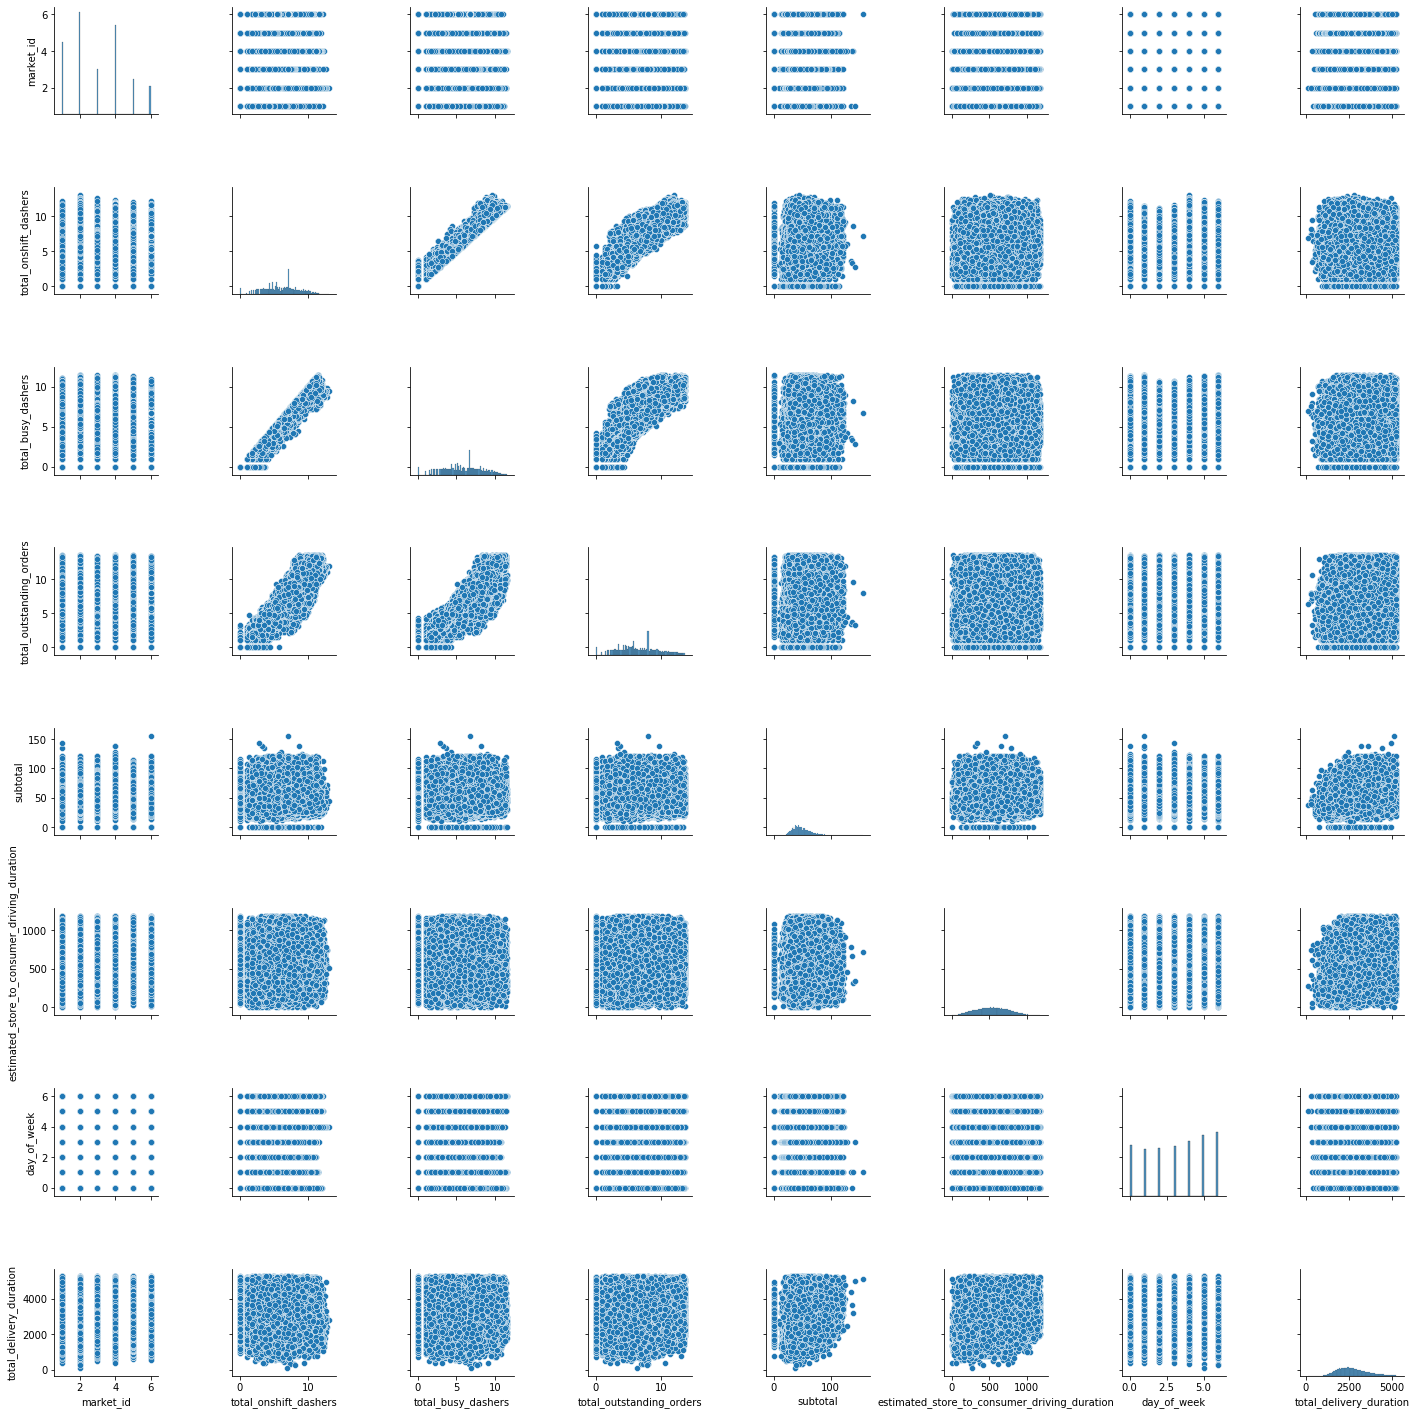

In [48]:
sns.pairplot(train_data)

In [49]:
## dropping rows with remaing missing values

train_data=train_data.dropna()
train_data = train_data.drop(['market_id'],axis=1)

valid_data=valid_data.dropna()
valid_data = valid_data.drop(['market_id'],axis=1)

In [50]:
train_data = pd.get_dummies(train_data)
train_data.head()

,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,subtotal,estimated_store_to_consumer_driving_duration,day_of_week,total_delivery_duration,time_of_day_late_night,time_of_day_morning,time_of_day_lunch,time_of_day_dinner
148761,8.602325,8.602325,5.099020,51.961524,674.0,5,2773.0,1,0,0,0
20248,10.770330,8.944272,12.409674,42.308392,541.0,6,2922.0,1,0,0,0
33210,5.196152,3.741657,3.741657,51.623638,231.0,0,2537.0,1,0,0,0
32256,7.141428,7.000000,7.681146,40.000000,862.0,4,3058.0,1,0,0,0
1305,5.099020,5.099020,6.403124,78.898669,573.0,5,2563.0,1,0,0,0


In [51]:
valid_data = pd.get_dummies(valid_data)
valid_data.head()


,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,subtotal,estimated_store_to_consumer_driving_duration,day_of_week,total_delivery_duration,time_of_day_late_night,time_of_day_morning,time_of_day_lunch,time_of_day_dinner
175813,6.000000,6.000000,3.741657,44.090815,495.0,5,3643.0,0,0,0,1
79762,6.000000,6.000000,5.291503,45.803930,196.0,3,1366.0,0,0,0,1
80915,5.916080,5.916080,6.928203,55.991071,501.0,6,2403.0,0,0,0,1
155400,3.162278,2.449490,1.732051,29.916551,816.0,0,2021.0,0,0,0,1
78044,4.795832,4.472136,4.795832,0.000000,573.0,6,1957.0,0,0,0,1


In [52]:
y_train = train_data['total_delivery_duration']
X_train = train_data.drop(['total_delivery_duration'],axis=1)

y_test = valid_data['total_delivery_duration']
X_test = valid_data.drop(['total_delivery_duration'],axis=1)

In [53]:
train_data.head()

,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,subtotal,estimated_store_to_consumer_driving_duration,day_of_week,total_delivery_duration,time_of_day_late_night,time_of_day_morning,time_of_day_lunch,time_of_day_dinner
148761,8.602325,8.602325,5.099020,51.961524,674.0,5,2773.0,1,0,0,0
20248,10.770330,8.944272,12.409674,42.308392,541.0,6,2922.0,1,0,0,0
33210,5.196152,3.741657,3.741657,51.623638,231.0,0,2537.0,1,0,0,0
32256,7.141428,7.000000,7.681146,40.000000,862.0,4,3058.0,1,0,0,0
1305,5.099020,5.099020,6.403124,78.898669,573.0,5,2563.0,1,0,0,0


# MODELLING

In [54]:
## Custom cost function

def new_mae(actual, predicted):
    sum_error =0
    for i in range(len(actual)):
        error = actual[i]-predicted[i]
        if error > 0:
            sum_error += abs(2*error)
        else:
            sum_error += (error)
            
        
    return sum_error/len(actual)

custom_mse_score = make_scorer(new_mae, greater_is_better = False)


## this function gives the average of negative and positive errors separately
def pos_neg_deviation(true, predict):
    
    neg_n=0
    pos_n=0
    pos =0
    neg =0

    for i in range(len(true)):
        error = np.array(true)[i] - predict[i]
        #print(error)
        if error <= 0:
            neg_n+=1
            neg+= abs(error)
        else:
            pos_n+=1
            pos += abs(error)

    print(neg/neg_n)
    print(pos/pos_n)
    
    return 


mae = make_scorer(new_mae,greater_is_better=False)

### RANDOM FOREST REGRESSION

In [55]:
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_features = ['auto', 'sqrt']
#max_depth = [int(x) for x in np.linspace(10, 60, num = 6)]
#max_depth.append(None)
min_samples_split = [2]#, 5, 10]
min_samples_leaf = [1]#, 2, 4]
bootstrap = [True]#, False]

param_grid = {'n_estimators': [50],
              'max_depth':[None],
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestRegressor()
rf_model = GridSearchCV(estimator = rf, param_grid = param_grid,scoring= mae, 
                          cv = 3, n_jobs = -1, verbose = 2)

rf_model.fit(X_train, y_train)

best_rf = rf_model.best_estimator_




Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\tetteh\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan]
  category=UserWarning


In [79]:

###checking model performance on the training data

train_pred_rand = best_rf.predict(X_train)

train_score = mean_absolute_error(y_train, train_pred_rand)
train_score

228.63898682662685

In [80]:
## prediction and checking loss using the custom mean square error on the validation dataset

rand_pred = best_rf.predict(np.array(X_test))

valid_score =  mean_absolute_error(y_test, rand_pred)

valid_score

697.1249364898947

In [67]:
pos_neg_deviation(y_test, rand_pred)

558.5396316998812
860.7612142434416


Text(0.5, 0, 'Random Forest Feature Importance')

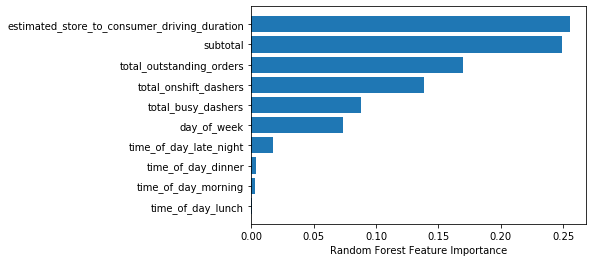

In [73]:

sorted_idx = best_rf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], best_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [68]:
mse = make_scorer(mean_absolute_error,greater_is_better=False)

### XGBOOST REGRESSION

In [70]:
xgb = XGBRegressor()

# A parameter grid for XGBoost

## would have loved to use wider range of hyperparamters for the gridsearch but I dont have the computing power
params = {
        'min_child_weight': [1],
        'gamma': [0.5, 1],
        'subsample': [0.6],
        'colsample_bytree': [0.6],
        'max_depth': [3]
        }


xgb_model = GridSearchCV(xgb, params, n_jobs=5, 
                   cv=5, scoring= mae, 
                   
                   verbose=3, refit=True)

xgb_model.fit(X_train,y_train)

best_xgb = xgb_model.best_estimator_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[12:22:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [74]:
model = XGBRegressor (   n_estimators = 200,
                                            min_child_weight = 1, 
                                            subsample = 0.6, 
                                           cosample_bytree = 0.6,
                                           alpha = 0.05,
                                           eta = 0.1, 
                                          )


model.fit(X_train,y_train, eval_metric="mae", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds = 20)

[17:48:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:2444.98	validation_1-mae:2585.31
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 20 rounds.
[1]	validation_0-mae:2201.16	validation_1-mae:2340.19
[2]	validation_0-mae:1980.83	validation_1-mae:2119.15
[3]	validation_0-mae:1782.92	validation_1-mae:1919.95
[4]	validation_0-mae:1605.07	validation_1-mae:1741.36
[5]	validation_0-mae:1446.44	validation_1-mae:1581.27
[6]	validation_0-mae:1306.98	validation_1-mae:1440.73
[7]	validation_0-mae:1185.6	validation_1-mae:1318.26
[8]	validation_0-mae:1081.25	validation_1-mae:1213.21
[9]	validation_0-mae:993.604	validation_1-mae:1123.81
[10]	validation_0-mae:920.216	validation_1-mae:1048.92
[11]	validation_0-mae:860.119	validation_1-mae:987.189
[12]	validation_0-mae:810.851	validation_1-mae:935.928
[13]	validation_0-mae:7

XGBRegressor(alpha=0.05, cosample_bytree=0.6, eta=0.1, n_estimators=200,
             subsample=0.6)

In [77]:
###checking model performance on the training data

train_pred_xgb = model.predict(X_train)

train_score = mean_absolute_error(y_train, train_pred_xgb)
train_score

589.8453595483855

In [78]:
xgb_pred = best_xgb.predict(X_test)

valid_score_xgb = mean_absolute_error(y_test, xgb_pred)
valid_score_xgb

697.7381171697401

In [ ]:
# feature importance
print(best_xgb.feature_importances_)
# plot
plt.bar(range(len(best_xgb.feature_importances_)),best_xgb.feature_importances_)
plt.show()


In [ ]:
for i in range(len(X_train.columns)):
    print(X_train.columns[i],i)

In [ ]:
from xgboost import plot_importance

# plot feature importance
plot_importance(best_xgb)
plt.show()


### LINEAR REGRESSION

In [72]:
from sklearn.linear_model import ElasticNet

# find optimal alpha with grid search
alpha = [0,0.001, 0.01, 0.1,0.2,0.3,0.4]
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4,0.5,0.6]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)


elastic_net = ElasticNet()

grid = GridSearchCV(estimator=elastic_net, param_grid=param_grid, scoring=mse, verbose=1, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

best = grid_result.best_estimator_

Fitting 5 folds for each of 49 candidates, totalling 245 fits


C:\Users\tetteh\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\tetteh\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\tetteh\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37684752613.1999, tolerance: 9870575.410819473
  positive)


In [94]:
linear_pred = grid_result.best_estimator_.predict(X_test)

mean_squared_error(y_test, linear_pred)

2863187.6652442776

In [ ]:
# get importance
importance = best.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Preprocessing data for final prediction

##### Outline
- dealing with negative values
- Uplevel total onshift dashers for those lower than total busy dashers
- square root  transformation

In [86]:
predict_data.head()

,market_id,created_at,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id,time_of_day,day_of_week
0,3.0,2015-02-25 02:22:30,5477,7500,4.0,4.0,4.0,670.0,194096,late_night,2
1,3.0,2015-02-25 01:14:19,5477,7100,4.0,1.0,1.0,446.0,236895,late_night,2
2,4.0,2015-02-22 02:27:44,5477,4500,9.0,7.0,6.0,504.0,190868,late_night,6
3,3.0,2015-02-25 01:32:39,5477,1700,3.0,3.0,3.0,687.0,183076,late_night,2
4,1.0,2015-02-24 05:20:45,2841,3150,4.0,4.0,4.0,528.0,186200,morning,1


In [87]:
predict_data.describe()

,market_id,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_id,day_of_week
count,54528.000000,54778.000000,54778.000000,54778.000000,54778.000000,54778.000000,54778.000000,54778.000000,54778.000000
mean,3.031360,3489.640969,2715.758772,48.454196,42.981480,61.500669,547.764714,126118.103454,3.225273
std,1.531606,2050.221801,1897.919808,36.214949,32.779963,54.290945,220.437715,72683.611935,2.069463
min,1.000000,2.000000,0.000000,-1.000000,-4.000000,-9.000000,0.000000,20.000000,0.000000
25%,2.000000,1661.000000,1420.000000,20.000000,17.000000,21.000000,385.000000,62938.500000,1.000000
50%,3.000000,3518.000000,2220.000000,41.000000,37.000000,46.000000,544.000000,126194.000000,3.000000
75%,4.000000,5247.000000,3415.000000,67.000000,60.000000,85.000000,703.000000,188916.000000,5.000000
max,6.000000,6986.000000,29925.000000,175.000000,169.000000,292.000000,1550.000000,252031.000000,6.000000


In [88]:
predict_data.shape

(54778, 11)

In [89]:
#### dealing with bad data in prediction data
predict_data =  dealing_bad_data(predict_data)

##transformation
predict_data = sqrt_transform(predict_data)
delivery_id = predict_data['delivery_id']
predict_data = predict_data[['market_id','total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'subtotal','estimated_store_to_consumer_driving_duration', 'time_of_day', 'day_of_week']]




#train_data=train_data.dropna()

predict_data = predict_data.drop(['market_id'],axis=1)

predict_data = pd.get_dummies(predict_data)
predict_data.head()


,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,subtotal,estimated_store_to_consumer_driving_duration,day_of_week,time_of_day_late_night,time_of_day_morning,time_of_day_lunch,time_of_day_dinner
0,2.000000,2.000000,2.000000,86.602540,670.0,2,1,0,0,0
1,2.000000,1.000000,1.000000,84.261498,446.0,2,1,0,0,0
2,3.000000,2.645751,2.449490,67.082039,504.0,6,1,0,0,0
3,1.732051,1.732051,1.732051,41.231056,687.0,2,1,0,0,0
4,2.000000,2.000000,2.000000,56.124861,528.0,1,0,1,0,0


In [90]:
delivery_id

0        194096
1        236895
2        190868
3        183076
4        186200
          ...  
54773    174203
54774    138333
54775     34110
54776    178028
54777    132824
Name: delivery_id, Length: 54778, dtype: int64

In [91]:
prediction =  best_rf.predict(np.array(predict_data))
len(prediction)

54778

In [92]:
prediction =  best_rf.predict(np.array(predict_data))

data = {'delivery_id': delivery_id, 'predicted_duration': prediction}
submission = pd.DataFrame(data=data)

submission.to_csv('final.csv', index= False)

,delivery_id,predicted_duration
0,194096,3531.50
1,236895,3156.74
2,190868,2974.46
3,183076,3358.70
4,186200,2587.44
...,...,...
54773,174203,2856.94
54774,138333,2522.72
54775,34110,2177.38
54776,178028,2962.96


In [93]:
submission.to_csv('final.csv', index= False)

In [1]:
[1,2,3,4][3:3-1]

[]